<a href="https://colab.research.google.com/github/felixJPK/DeepFakeDetection_MachineLearningHandcraftFeat/blob/main/HOG_Example_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"felixjuwono","key":"9c9f8b0758a7fb891274fc62308cd930"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
100% 1.68G/1.68G [00:16<00:00, 219MB/s]
100% 1.68G/1.68G [00:16<00:00, 110MB/s]


In [ ]:
!unzip deepfake-and-real-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy
import tensorflow
import dlib

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
# from keras_vggface.vggface import VGGFace
# from keras_vggface import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.datasets import load_files
# from tensorflow.keras.utils import np_utils
from glob import glob
import pandas as pd
import cv2
import scipy.misc
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array, load_img
from collections import Counter
from scipy.signal import wiener
from skimage.feature import local_binary_pattern

Belum di faceblocking

In [ ]:
base_path = './Dataset/'
image_gen1 = ImageDataGenerator()
batch_size = 32

train_flow = image_gen1.flow_from_directory(
    base_path + 'Train/',
    target_size=(224, 224),
    batch_size = batch_size,
    class_mode = 'binary',
    color_mode = 'grayscale'
)


Found 140002 images belonging to 2 classes.


Preprocessing

In [ ]:

#importing required libraries
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
import cv2
import numpy as np
import dlib
from google.colab.patches import cv2_imshow

def preprocessing(image):
    # Load the image
    if image is None:
        print("Error loading image")
        return None
    else:
        # Initialize dlib face detector
        detector = dlib.get_frontal_face_detector()

        # Resize the image to a larger size for better detection
        image_resized = cv2.resize(image, (400, 400))  # Resize to a larger size for better detection
        image_resized = image_resized.astype(np.uint8)  # Convert to 8-bit



        # Print the number of faces detected
        # print(f"Detected {len(faces)} faces")

        # Detect faces using dlib
        faces = detector(image_resized)  # Detect faces with scaling

        # Only proceed if exactly one face is detected
        processed_images = []
        for face in faces:
            left, top, right, bottom = max(0, face.left()), max(0, face.top()), face.right(), face.bottom()

            # Ensure valid cropping coordinates and non-empty face region
            if left < right and top < bottom and image_resized[top:bottom, left:right].size != 0:
                cropped_face = image_resized[top:bottom, left:right]

                # Apply Face Blocking: Dividing the face into 9 regions (3x3 grid)
                height, width = cropped_face.shape[:2]
                grid_size_h = height // 3
                grid_size_w = width // 3

                # Loop through and divide the cropped face into 9 blocks (3x3 grid)
                for i in range(3):
                    for j in range(3):
                        # Define the coordinates for each block
                        block = cropped_face[i*grid_size_h:(i+1)*grid_size_h, j*grid_size_w:(j+1)*grid_size_w]



                        fd, hog_image = hog(block, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, channel_axis=None)
                        hog_image = cv2.resize(hog_image, (32, 32))  # Resize to 32x32
                        processed_images.append(hog_image)



    # Return processed images as a numpy array
    processed_images = np.array(processed_images)
    return processed_images


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
# from joblib import Parallel, delayed

# Maksimal batch yang ingin diproses
max_batches = 200

# List untuk menyimpan hasil split
train_data = []
train_labels = []
val_data = []
val_labels = []
test_data = []
test_labels = []

# Loop untuk memproses batch
for i, (batch_images, batch_labels) in enumerate(tqdm(train_flow, desc="Processing Batches")):
    if i >= max_batches:
        break

    # Loop through each image in the batch
    for idx, (image, label) in enumerate(zip(batch_images, batch_labels)):  # Process images individually with index
        processed_images = preprocessing(image)  # Pass a single image

        # Print index of the current image in the batch
        # print(f"Batch {i+1}, Image {idx+1}: Label = {label}")





        # Check if faces were detected, if not, skip the image
        # if image is None:  # Check if processed_images is None
        #     print(f"Skipping image due to no detected faces or multiple faces.")
        #     continue  # Skip this image and move to the next

        # Tentukan split berdasarkan indeks
        if i < max_batches * 0.7:  # 70% pertama untuk training
            train_data.append(image)
            train_labels.append(label)  # Append the label for the current image
        elif i < max_batches * 0.9:  # 20% berikutnya untuk validation
            val_data.append(image)
            val_labels.append(label)  # Append the label for the current image
        else:  # 10% terakhir untuk testing
            test_data.append(image)
            test_labels.append(label)  # Append the label for the current image

# Konversi hasil split ke numpy array
train_data = np.array(train_data)
train_labels = np.array(train_labels)
val_data = np.array(val_data)
val_labels = np.array(val_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Print jumlah data di setiap split untuk verifikasi
print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Train label size: {len(train_labels)}")
print(f"Validation label size: {len(val_labels)}")
print(f"Test label  size: {len(test_labels)}")

Processing Batches:   5%|▍         | 200/4376 [1:07:44<23:34:23, 20.32s/it]


Train set size: 4480
Validation set size: 1280
Test set size: 640
Train label size: 4480
Validation label size: 1280
Test label  size: 640


2560

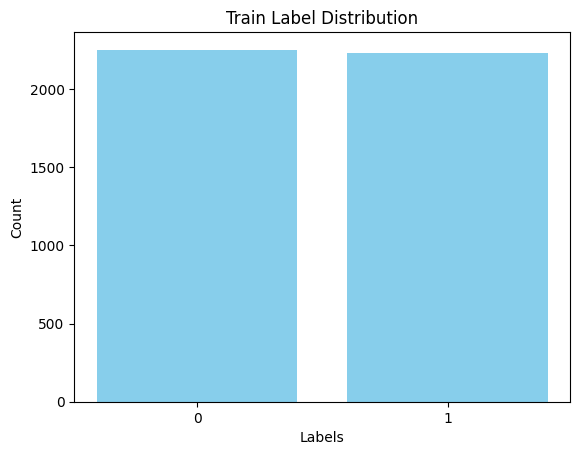

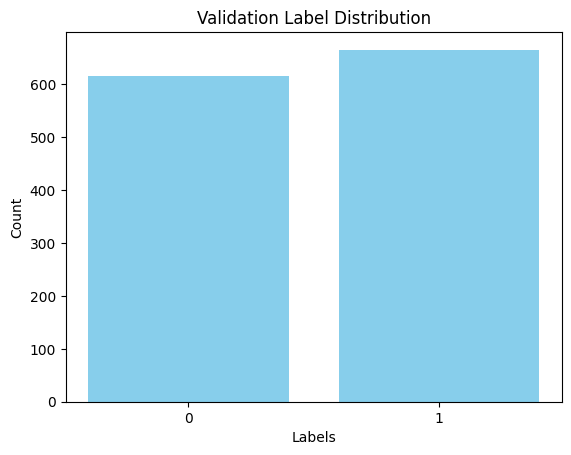

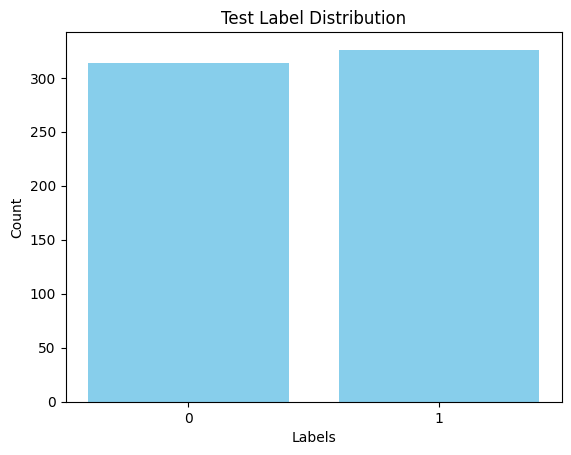

In [ ]:
import matplotlib.pyplot as plt

# Fungsi untuk membuat plot distribusi label
def plot_label_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts, color='skyblue')
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(unique)
    plt.show()

# Plot distribusi label
plot_label_distribution(train_labels, "Train Label Distribution")
plot_label_distribution(val_labels, "Validation Label Distribution")
plot_label_distribution(test_labels, "Test Label Distribution")


In [ ]:
train_data.shape

(4480, 224, 224, 1)

In [ ]:
print(f"Jumlah fitur: {train_data.shape[1]}")
print(f"Jumlah sampel: {train_data.shape[0]}")


Jumlah fitur: 224
Jumlah sampel: 4480


In [ ]:
train_data_flat = train_data.reshape(train_data.shape[0], -1)  # Menjadi (1120, 224*224 = 50176)
val_data_flat = val_data.reshape(val_data.shape[0], -1)
test_data_flat = test_data.reshape(test_data.shape[0], -1)



In [ ]:
train_data_flat.shape


(4480, 50176)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)
train_data_flat = pca.fit_transform(train_data_flat)
val_data_flat = pca.transform(val_data_flat)
test_data_flat = pca.transform(test_data_flat)


In [ ]:
train_labels.shape

(4480,)

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Normalisasi data menggunakan StandardScaler
scaler = StandardScaler()
train_data_flat = scaler.fit_transform(train_data_flat)
val_data_flat = scaler.transform(val_data_flat)
test_data_flat = scaler.transform(test_data_flat)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Fungsi untuk menghitung performa model (J)
def evaluate_performance(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return accuracy_score(y_val, y_pred)

# Fungsi untuk seleksi fitur
def feature_selection(X, y, model):
    n_features = X.shape[1]
    half = n_features // 2

    # Inisialisasi subset fitur dengan paruh pertama
    selected_features = list(range(half))
    X_selected = X[:, selected_features]

    # Proses seleksi fitur paruh kedua
    for i in range(half, n_features):
        temp_features = selected_features + [i]
        X_temp = X[:, temp_features]
        if evaluate_performance(model, X_temp, y) > evaluate_performance(model, X_selected, y):
            selected_features.append(i)

    # Buang semua fitur paruh pertama dan evaluasi ulang
    selected_features = [f for f in selected_features if f >= half]
    # if not selected_features:  # If selected_features is empty
    #     selected_features = list(range(n_features))  # Use all features

    # Proses seleksi fitur paruh pertama kembali
    for i in range(half):
        temp_features = selected_features + [i]
        X_temp = X[:, temp_features]
        if evaluate_performance(model, X_temp, y) > evaluate_performance(model, X[:, selected_features], y):
            selected_features.append(i)

    return selected_features

In [ ]:
from sklearn.svm import SVC
svm_classifier = SVC()

selected_features = feature_selection(train_data_flat, train_labels, svm_classifier)

# Gunakan hanya fitur yang terpilih untuk training, validation, dan test
train_data_selected = train_data_flat[:, selected_features]
val_data_selected = val_data_flat[:, selected_features]
test_data_selected = test_data_flat[:, selected_features]


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform
import numpy as np

param_distributions = {
   'C': uniform(loc=0.1, scale=10),  # C antara 0.1 dan 10
    'gamma': uniform(loc=0.001, scale=0.1),  # gamma antara 0.001 dan 0.1
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # berbagai jenis kernel
    'degree': [2, 3, 4, 5],  # derajat kernel polynomial (hanya berlaku jika kernel='poly')
    'class_weight': [None, 'balanced'],  # opsi untuk penanganan imbalance
}
# Randomized search dengan 20 iterasi
random_search = RandomizedSearchCV(
    estimator=svm_classifier,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    random_state=42,
    n_jobs=-1  # gunakan semua core CPU yang tersedia
)

# Fit model dengan data training
random_search.fit(train_data_selected, train_labels)

# Menampilkan hasil terbaik
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Evaluasi model terbaik pada data validation
best_model = random_search.best_estimator_
val_score = best_model.score(val_data_selected, val_labels)
print("Validation accuracy:", val_score)


Best parameters: {'C': 0.6641157902710025, 'class_weight': 'balanced', 'degree': 5, 'gamma': 0.09485527090157503, 'kernel': 'rbf'}
Best cross-validation score: 0.6781241211030026
Validation accuracy: 0.6828125


In [ ]:
svm_classifier = SVC(**random_search.best_params_)




In [ ]:

# Latih model dengan data training
svm_classifier.fit(train_data_selected, train_labels)

# Evaluasi model pada data training, validation, dan test
train_predictions = svm_classifier.predict(train_data_selected)
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f"Training Accuracy: {train_accuracy:.2f}")

val_predictions = svm_classifier.predict(val_data_selected)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

test_predictions = svm_classifier.predict(test_data_selected)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")


Training Accuracy: 0.90
Validation Accuracy: 0.68
Test Accuracy: 0.71


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluasi model pada data test
# test_predictions = svm_classifier.predict(test_data_selected)

# Hitung akurasi pada data test
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Tampilkan classification report
report = classification_report(test_labels, test_predictions, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(report)


Test Accuracy: 0.71
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.73      0.64      0.69       314
     Class 1       0.69      0.78      0.73       326

    accuracy                           0.71       640
   macro avg       0.71      0.71      0.71       640
weighted avg       0.71      0.71      0.71       640



In [ ]:
import pickle

In [ ]:
# Simpan model ke file pickle
model_filename = "svm_classifier_HOG.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(svm_classifier, file)

print(f"Model telah disimpan ke file '{model_filename}'")